In [1]:
# %%
import pandas as pd 

train_df = pd.read_csv("/kaggle/input/imdb-2/train_data_final_2.csv")
test_df = pd.read_csv("/kaggle/input/imdb-2/test_data_final_2.csv")

print("Training Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())


Training Data:
                                    tokenized_review  label  \
0  ['bromwell', 'high', 'cartoon', 'comedy', 'ran...      1   
1  ['homelessness', 'houselessness', 'george', 'c...      1   
2  ['brilliant', 'overacting', 'lesley', 'ann', '...      1   
3  ['easily', 'underrated', 'film', 'inn', 'brook...      1   
4  ['typical', 'mel', 'brooks', 'film', 'slapstic...      1   

                                       padded_review  
0  [1, 7323, 2274, 2956, 12444, 15823, 12104, 136...  
1  [1, 1, 6465, 1, 14855, 8270, 17417, 11633, 724...  
2  [1864, 11048, 1, 580, 16961, 1411, 4634, 1, 87...  
3  [4836, 16350, 5810, 7999, 1904, 2164, 15282, 5...  
4  [16264, 9793, 1904, 5810, 14290, 10269, 151, 1...  

Test Data:
                                    tokenized_review  label  \
0  ['went', 'saw', 'movie', 'night', 'coaxed', 'f...      1   
1  ['actor', 'turned', 'director', 'bill', 'paxto...      1   
2  ['recreational', 'golfer', 'knowledge', 'sport...      1   
3  ['saw', '

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import ast  # For safely evaluating strings containing Python literals
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

vocab_size = 17502  # Size of the vocabulary

def index_to_one_hot(index, vocab_size):
    """ Convert an index to a one-hot encoded vector """
    one_hot = torch.zeros(vocab_size)
    one_hot[index] = 1
    return one_hot

class SentimentDataset(Dataset):
    def __init__(self, dataframe):
        self.reviews = dataframe['padded_review']
        self.labels = dataframe['label']

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        indices = self.reviews.iloc[idx]
        indices = [min(index, vocab_size - 1) for index in indices]
        one_hot_encoded = torch.stack([index_to_one_hot(index, vocab_size) for index in indices])
        return one_hot_encoded, self.labels.iloc[idx]



train_df = pd.read_csv('/kaggle/input/imdb-2/train_data_final_2.csv')
# train_df = train_df.sample(n=400, random_state=42)  # Sampling 1000 examples due to dataset size

test_df = pd.read_csv('/kaggle/input/imdb-2/test_data_final_2.csv')
# test_df = test_df.sample(n=200, random_state=42)  # Sampling 1000 examples due to dataset size



train_data, dev_data = train_test_split(train_df, test_size=0.2, random_state=42)

test_data = test_df

max_length = 105  


train_df['padded_review'] = train_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])
dev_df = train_df.sample(frac=0.1, random_state=42)
train_df = train_df.drop(dev_df.index)
test_df['padded_review'] = test_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])

train_df['label'] = pd.to_numeric(train_df['label'])
dev_df['label'] = pd.to_numeric(dev_df['label'])
test_df['label'] = pd.to_numeric(test_df['label'])

train_dataset = SentimentDataset(train_df)
dev_dataset = SentimentDataset(dev_df)
test_dataset = SentimentDataset(test_df)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in dev loader: {len(dev_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")



Number of batches in training loader: 23
Number of batches in dev loader: 3
Number of batches in test loader: 13


In [59]:
for X_batch, y_batch in train_loader:
    print("Batch X shape:", X_batch.shape)
    print("Batch Y shape:", y_batch.shape)
    print("Batch X content:\n", X_batch)
    print("Batch Y content:", y_batch)
    break


Batch X shape: torch.Size([16, 105, 17502])
Batch Y shape: torch.Size([16])
Batch X content:
 tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  .

In [60]:
import torch

torch.cuda.empty_cache()
torch.cuda.empty_cache()


In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import copy
import matplotlib.pyplot as plt

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, dropout_rate=0.5):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout after first layer
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout after second layer
        self.output = nn.Linear(hidden2_size, output_size)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        x = x.view(x.size(0), -1)  # [batch_size, 100*2000] = [batch_size, 200000]
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)  # Apply first dropout
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)  # Apply second dropout
        out = self.output(out)
        out = self.sigmoid(out).squeeze()
        return out

# Parameters
input_size = 105 * 17502
hidden1_size = 256
hidden2_size = 128
output_size = 1  # Binary classification
learning_rate = 0.001
num_epochs = 10
dropout_rate = 0.5
patience = 3  # Early stopping patience


model = FeedForwardNN(input_size, hidden1_size, hidden2_size, output_size, dropout_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

FeedForwardNN(
  (fc1): Linear(in_features=1837710, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Total number of parameters: 470487041


In [64]:

best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


def train_model(model, train_loader, val_loader, num_epochs, patience):
    global best_val_loss, epochs_no_improve, early_stop

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted_train = (outputs > 0.5).float()
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        val_loss, val_acc = validate_model(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping!")
            model.load_state_dict(best_model)  
            break

        
        torch.cuda.empty_cache()

def validate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

            predicted_val = (outputs > 0.5).float()
            correct_val += (predicted_val == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    return val_loss, val_acc



train_model(model, train_loader, dev_loader, num_epochs, patience)




Epoch 1/10, Train Loss: 0.6954, Train Acc: 0.4833, Val Loss: 0.6908, Val Acc: 0.4500
Epoch 2/10, Train Loss: 0.6474, Train Acc: 0.6556, Val Loss: 0.6872, Val Acc: 0.5000
Epoch 3/10, Train Loss: 0.4401, Train Acc: 0.8750, Val Loss: 0.6627, Val Acc: 0.5500
Epoch 4/10, Train Loss: 0.1170, Train Acc: 0.9750, Val Loss: 0.6676, Val Acc: 0.6000
Epoch 5/10, Train Loss: 0.0277, Train Acc: 0.9944, Val Loss: 0.7229, Val Acc: 0.5750
Epoch 6/10, Train Loss: 0.0037, Train Acc: 1.0000, Val Loss: 0.7467, Val Acc: 0.5750
Early stopping!


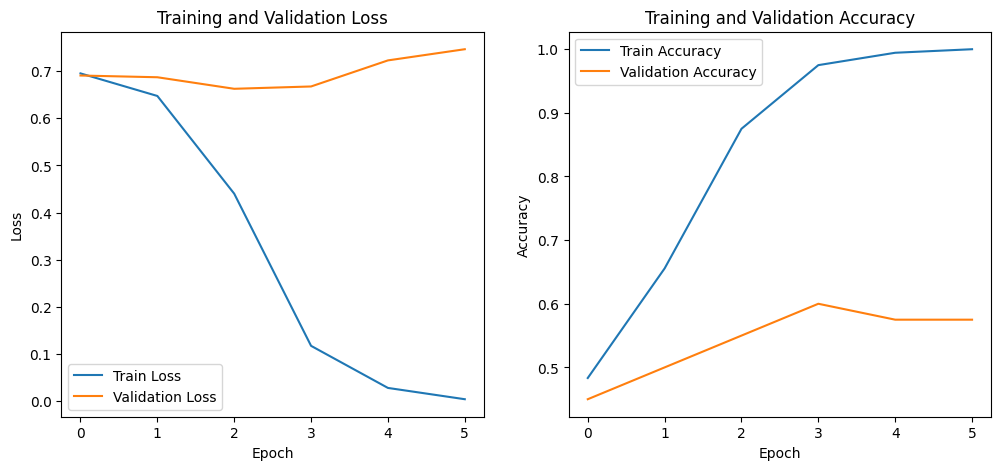

In [65]:

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [66]:
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device).float()
        outputs = model(batch_X)
        preds = (outputs >= 0.5).long()
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch_Y.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Detailed metrics for each class
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    test_labels, test_preds, labels=[0,1]
)

print("\nPer Class Metrics:")
print(f"Class 0 - Precision: {precision_per_class[0]:.4f}, Recall: {recall_per_class[0]:.4f}, F1-Score: {f1_per_class[0]:.4f}")
print(f"Class 1 - Precision: {precision_per_class[1]:.4f}, Recall: {recall_per_class[1]:.4f}, F1-Score: {f1_per_class[1]:.4f}")


Test Accuracy: 0.5200
Test Precision: 0.5849
Test Recall: 0.2952
Test F1-Score: 0.3924

Per Class Metrics:
Class 0 - Precision: 0.4966, Recall: 0.7684, F1-Score: 0.6033
Class 1 - Precision: 0.5849, Recall: 0.2952, F1-Score: 0.3924


## RNNS

In [2]:
import torch
import pandas as pd 
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import ast 

class SentimentDataset(Dataset):
    def __init__(self, dataframe, max_length=105, vocab_size=10000):
        self.reviews = dataframe['padded_review']
        self.labels = dataframe['label']
        self.max_length = max_length
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        indices = self.reviews.iloc[idx]
        multi_hot_vector = torch.zeros(self.vocab_size)
        for index in indices:
            if index < self.vocab_size:
                multi_hot_vector[index] = 1
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return multi_hot_vector, label



vocab_size = 17502
max_length = 105
batch_size = 16

train_df = pd.read_csv('/kaggle/input/imdb-2/train_data_final_2.csv')
# train_df = train_df.sample(n=400, random_state=42)  # Sampling 1000 examples due to dataset size

test_df = pd.read_csv('/kaggle/input/imdb-2/test_data_final_2.csv')
# test_df = test_df.sample(n=200, random_state=42)  # Sampling 1000 examples due to dataset size


train_data, dev_data = train_test_split(train_df, test_size=0.2, random_state=42)

test_data = test_df

max_length = 105  

train_df['padded_review'] = train_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])
dev_df = train_df.sample(frac=0.1, random_state=42)
train_df = train_df.drop(dev_df.index)
test_df['padded_review'] = test_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])

train_df['label'] = pd.to_numeric(train_df['label'])
dev_df['label'] = pd.to_numeric(dev_df['label'])
test_df['label'] = pd.to_numeric(test_df['label'])

train_dataset = SentimentDataset(train_df)
dev_dataset = SentimentDataset(dev_df)
test_dataset = SentimentDataset(test_df)

batch_size = 16

train_dataset = SentimentDataset(train_df, max_length=max_length, vocab_size=vocab_size)
dev_dataset = SentimentDataset(dev_df, max_length=max_length, vocab_size=vocab_size)
test_dataset = SentimentDataset(test_df, max_length=max_length, vocab_size=vocab_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in dev loader: {len(dev_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")


Number of batches in training loader: 1407
Number of batches in dev loader: 157
Number of batches in test loader: 1563


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import copy
import matplotlib.pyplot as plt

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(SentimentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            vocab_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            nonlinearity='tanh'
        )

        self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

            out, _ = self.rnn(x.unsqueeze(1), h0)

            out = out[:, -1, :]

            out = self.fc(out)

            return out

vocab_size = 17502
embedding_dim = 128
hidden_size = 256
output_size = 2
num_layers = 1
dropout = 0.5
learning_rate = 0.001
num_epochs = 50
patience = 5
min_delta = 0.001

model = SentimentRNN(vocab_size, hidden_size, output_size, num_layers, dropout)

print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


SentimentRNN(
  (rnn): RNN(17502, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [5]:
train_losses = []
dev_losses = []
train_accuracies = []
dev_accuracies = []

best_dev_accuracy = 0.0
best_model_state = copy.deepcopy(model.state_dict())
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == batch_Y).sum().item()
        total_train += batch_Y.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    dev_running_loss = 0.0
    correct_dev = 0
    total_dev = 0
    with torch.no_grad():
        for batch_X, batch_Y in dev_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            dev_running_loss += loss.item() * batch_X.size(0)
            _, preds = torch.max(outputs, 1)
            correct_dev += (preds == batch_Y).sum().item()
            total_dev += batch_Y.size(0)

    epoch_dev_loss = dev_running_loss / len(dev_loader.dataset)
    epoch_dev_acc = correct_dev / total_dev
    dev_losses.append(epoch_dev_loss)
    dev_accuracies.append(epoch_dev_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Dev Loss: {epoch_dev_loss:.4f}, Dev Acc: {epoch_dev_acc:.4f}")

    if epoch_dev_acc > best_dev_accuracy + min_delta:
        best_dev_accuracy = epoch_dev_acc
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_state)
print(f"\nBest Dev Accuracy: {best_dev_accuracy:.4f}")


Epoch [1/50], Train Loss: 0.3555, Train Acc: 0.8452, Dev Loss: 0.3023, Dev Acc: 0.8668
Epoch [2/50], Train Loss: 0.1876, Train Acc: 0.9296, Dev Loss: 0.3464, Dev Acc: 0.8628
Epoch [3/50], Train Loss: 0.1182, Train Acc: 0.9555, Dev Loss: 0.4293, Dev Acc: 0.8596
Epoch [4/50], Train Loss: 0.0755, Train Acc: 0.9706, Dev Loss: 0.5007, Dev Acc: 0.8512
Epoch [5/50], Train Loss: 0.0497, Train Acc: 0.9813, Dev Loss: 0.6392, Dev Acc: 0.8524
Epoch [6/50], Train Loss: 0.0326, Train Acc: 0.9877, Dev Loss: 0.7849, Dev Acc: 0.8516
Early stopping triggered.

Best Dev Accuracy: 0.8668


In [6]:
# Evaluation on Test Set
model.eval()
test_preds = []
test_labels = []
test_running_loss = 0.0
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)
        outputs = model(batch_X)  # [batch_size, output_size]
        loss = criterion(outputs, batch_Y)
        test_running_loss += loss.item() * batch_X.size(0)

        _, preds = torch.max(outputs, 1)  # [batch_size]
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch_Y.cpu().numpy())

test_loss = test_running_loss / len(test_loader.dataset)
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    test_labels, test_preds, labels=[0, 1]
)

print("\nPer Class Metrics:")
print(f"Class 0 - Precision: {precision_per_class[0]:.4f}, Recall: {recall_per_class[0]:.4f}, F1-Score: {f1_per_class[0]:.4f}")
print(f"Class 1 - Precision: {precision_per_class[1]:.4f}, Recall: {recall_per_class[1]:.4f}, F1-Score: {f1_per_class[1]:.4f}")




Test Loss: 0.3473
Test Accuracy: 0.8478
Test Precision: 0.8557
Test Recall: 0.8366
Test F1-Score: 0.8460

Per Class Metrics:
Class 0 - Precision: 0.8401, Recall: 0.8590, F1-Score: 0.8494
Class 1 - Precision: 0.8557, Recall: 0.8366, F1-Score: 0.8460


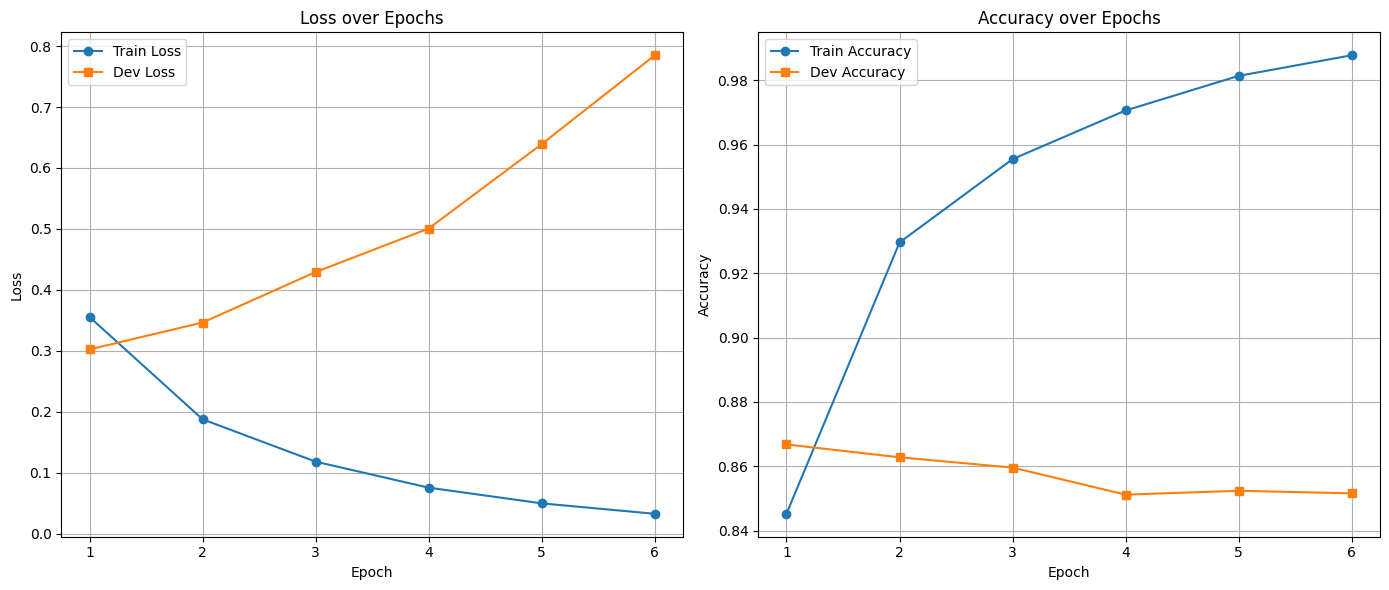

In [7]:

plt.figure(figsize=(14, 6))

# Plot Training and Development Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, len(dev_losses) + 1), dev_losses, marker='s', label='Dev Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Training and Development Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(dev_accuracies) + 1), dev_accuracies, marker='s', label='Dev Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [11]:

def predict_sentiment(sentence, model, vocab, max_length=105, vocab_size=17502):
    tokens = [vocab.get(word, 0) for word in sentence.split()]
    tokens = tokens[:max_length] + [0] * (max_length - len(tokens))
    multi_hot_vector = torch.zeros(vocab_size)
    for index in tokens:
        if index < vocab_size:
            multi_hot_vector[index] = 1
    multi_hot_vector = multi_hot_vector.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(multi_hot_vector)
    _, predicted = torch.max(output, 1)
    sentiment = "Positive" if predicted.item() == 1 else "Negative"
    print(f"Predicted label for the input sentence: {sentiment}")


sentence = "this was a good movie after all"
predict_sentiment(sentence, model, vocab)


Predicted label for the input sentence: Positive


#### Ends. 